# MLB Wins and Loses Model

In [1]:
%matplotlib inline

In [2]:
from pylab import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from mpl_toolkits.mplot3d import Axes3D

## Data

In [3]:
#Datasets
team_reg_bat = pd.DataFrame.from_csv('data/team.csv', index_col = None, encoding = ('utf-8'))

In [4]:
team_reg_bat.columns

Index(['year', 'league_id', 'team_id', 'franchise_id', 'div_id', 'rank', 'g',
       'ghome', 'w', 'l', 'div_win', 'wc_win', 'lg_win', 'ws_win', 'r', 'ab',
       'h', 'double', 'triple', 'hr', 'bb', 'so', 'sb', 'cs', 'hbp', 'sf',
       'ra', 'er', 'era', 'cg', 'sho', 'sv', 'ipouts', 'ha', 'hra', 'bba',
       'soa', 'e', 'dp', 'fp', 'name', 'park', 'attendance', 'bpf', 'ppf',
       'team_id_br', 'team_id_lahman45', 'team_id_retro'],
      dtype='object')

## Cleaning Data

In [5]:
team_rb = team_reg_bat.loc[team_reg_bat['year'] >= 2005, :]

In [6]:
####### Team Column Labeling #######

#Team Regular Season Batting
team_reg_bat = team_reg_bat.fillna(0)
tr_ab = team_rb['ab']
tr_bb = team_rb['bb']
tr_hbp = team_rb['hbp']
tr_sf = team_rb['sf']
tr_h = team_rb['h']
tr_dou = team_rb['double']
tr_tri = team_rb['triple']
tr_hr = team_rb['hr']
tr_sin = tr_h - (tr_dou + tr_tri + tr_hr)
trb_teamid = team_rb['team_id']
tr_bso = team_rb['so'].dropna()
tr_sb = team_rb['sb']

In [7]:
####### Team Batting Statistic Calculations #######

#Batting Average
team_rb['bat_avg'] = tr_h/tr_ab
tr_avg = team_rb['bat_avg']
#Slugging Percentage
team_rb['slg'] = (tr_sin + 2*tr_dou + 3*tr_tri + 4*tr_hr)/tr_ab
tr_slg = team_rb['slg']
#On Base Percentage
team_rb['obp'] = (tr_h + tr_bb + tr_hbp)/(tr_ab + tr_bb + tr_hbp + tr_sf)
tr_obp = team_rb['obp']
#On Base PLus Slugging
team_rb['ops'] = tr_slg + tr_obp
tr_ops = team_rb['ops']
#Weighted On Base Average
team_rb['woba'] = (.69*tr_bb + .72*tr_hbp + .89*tr_sin + 1.27*tr_dou + 1.62*tr_tri + 2.10*tr_hr)/(tr_ab + tr_bb + tr_sf + tr_hbp)
tr_woba = team_rb['woba']
#Strikeout Percentage
team_rb['kperc'] = tr_bso / (tr_ab + tr_bb + tr_hbp + tr_sf)
tr_kperc = team_rb['kperc']

In [8]:
# Delete Outliers in Stats
team_rb_h = team_rb.loc[((team_rb.h >= np.mean(tr_h)-3*np.std(tr_h)) & (team_rb.h <= np.mean(tr_h)+3*np.std(tr_h))), :]
team_rb_d = team_rb.loc[((team_rb.double >= np.mean(tr_dou)-3*np.std(tr_dou)) & (team_rb.double <= np.mean(tr_dou)+3*np.std(tr_dou))), :]
team_rb_t = team_rb.loc[((team_rb.triple >= np.mean(tr_tri)-3*np.std(tr_tri)) & (team_rb.triple <= np.mean(tr_tri)+3*np.std(tr_tri))), :]
team_rb_hr = team_rb.loc[((team_rb.hr >= np.mean(tr_hr)-3*np.std(tr_hr)) & (team_rb.hr <= np.mean(tr_hr)+3*np.std(tr_hr))), :]
team_rb_so = team_rb.loc[((team_rb.so >= np.mean(tr_bso)-3*np.std(tr_bso)) & (team_rb.so <= np.mean(tr_bso)+3*np.std(tr_bso))), :]
team_rb_bb = team_rb.loc[((team_rb.bb >= np.mean(tr_bb)-3*np.std(tr_bb)) & (team_rb.bb <= np.mean(tr_bb)+3*np.std(tr_bb))), :]
team_rb_h = team_rb.loc[((team_rb.h >= np.mean(tr_h)-3*np.std(tr_h)) & (team_rb.h <= np.mean(tr_h)+3*np.std(tr_h))), :]

In [9]:
# Deleting outliers in calculated stats
team_rb_avg = team_rb.loc[((team_rb.bat_avg >= np.mean(tr_avg)-3*np.std(tr_avg)) & (team_rb.bat_avg <= np.mean(tr_avg)+3*np.std(tr_avg))), :]
team_rb_slg = team_rb.loc[((team_rb.slg >= np.mean(tr_slg)-3*np.std(tr_slg)) & (team_rb.slg <= np.mean(tr_slg)+3*np.std(tr_slg))), :]
team_rb_obp = team_rb.loc[((team_rb.obp >= np.mean(tr_obp)-3*np.std(tr_obp)) & (team_rb.obp <= np.mean(tr_obp)+3*np.std(tr_obp))), :]
team_rb_ops = team_rb.loc[((team_rb.ops >= np.mean(tr_ops)-3*np.std(tr_ops)) & (team_rb.ops <= np.mean(tr_ops)+3*np.std(tr_ops))), :]
team_rb_woba = team_rb.loc[((team_rb.woba >= np.mean(tr_woba)-3*np.std(tr_woba)) & (team_rb.woba <= np.mean(tr_woba)+3*np.std(tr_woba))), :]
team_rb_kperc = team_rb.loc[((team_rb.kperc >= np.mean(tr_kperc)-3*np.std(tr_kperc)) & (team_rb.kperc <= np.mean(tr_kperc)+3*np.std(tr_kperc))), :]

## Distribution of Data

In [10]:
fig = plt.figure()

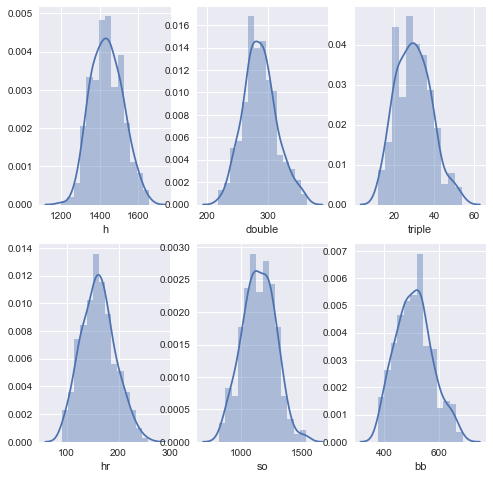

In [11]:
####### DISTRIBUTION PLOTS FOR TEAM OFFENSIVE STATS #######

fig, ax = plt.subplots(2,3,figsize=(8,8))

sns.distplot(team_rb_h.h, ax=ax[0,0])
sns.distplot(team_rb_d.double, ax=ax[0,1])
sns.distplot(team_rb_t.triple, ax=ax[0,2])
sns.distplot(team_rb_hr.hr, ax=ax[1,0])
sns.distplot(team_rb_so.so, ax=ax[1,1])
sns.distplot(team_rb_bb.bb, ax=ax[1,2])
None

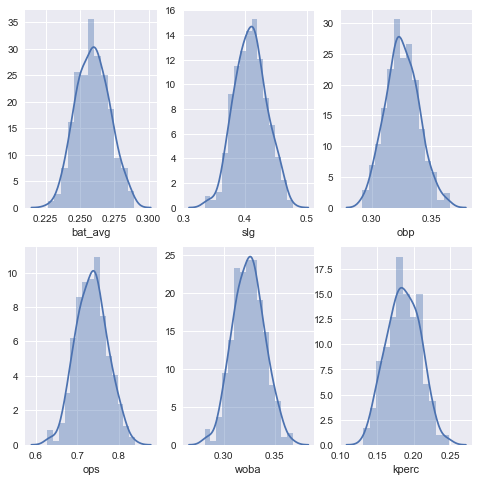

In [12]:
####### DISTRIBUTION PLOTS FOR TEAM CALCULATED OFFENSIVE STATS #######

fig, ax = plt.subplots(2,3,figsize=(8,8))

sns.distplot(team_rb_avg.bat_avg, ax=ax[0,0])
sns.distplot(team_rb_slg.slg, ax=ax[0,1])
sns.distplot(team_rb_obp.obp, ax=ax[0,2])
sns.distplot(team_rb_ops.ops, ax=ax[1,0])
sns.distplot(team_rb_woba.woba, ax=ax[1,1])
sns.distplot(team_rb_kperc.kperc, ax=ax[1,2])
None

## Non-Calculated Stat  vs. Wins Regression

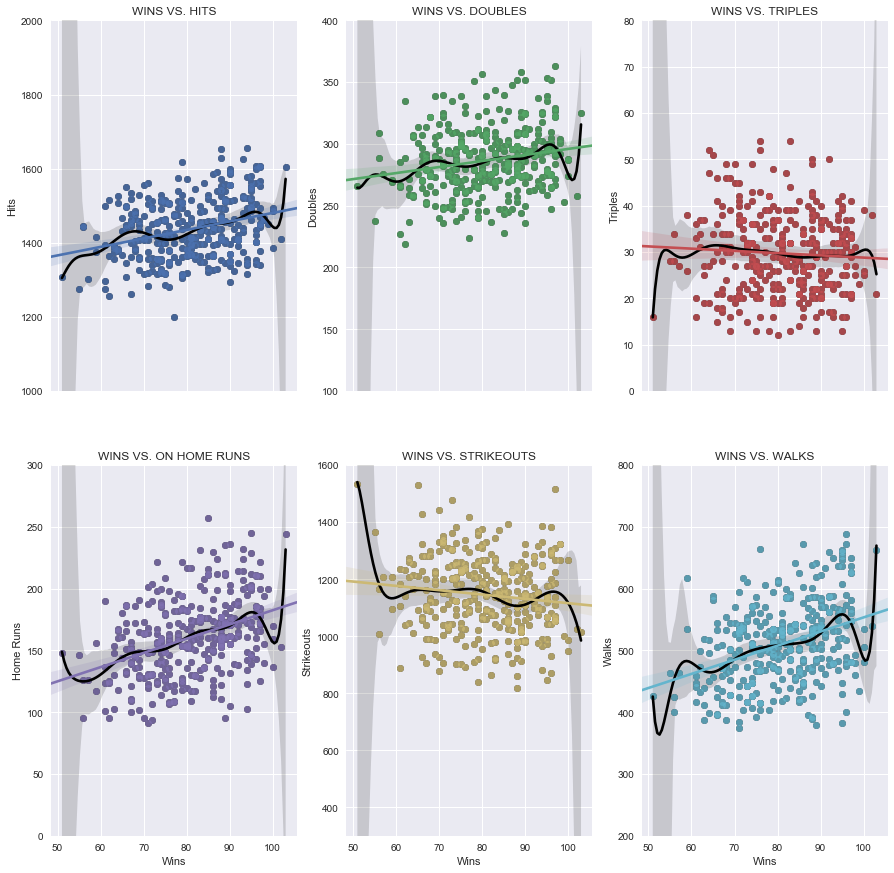

In [13]:
####### REGULAR SEASON STATS TO WINS #######

fig, ax = plt.subplots(2,3,figsize=(15,15), sharex = True)

# Hits Scatter
sns.regplot(x='w', y='h', data=team_rb_h, ax=ax[0,0], order=10, truncate=True, color='black')
sns.regplot(x='w', y='h', data=team_rb_h, ax=ax[0,0])
ax[0,0].set_title('WINS VS. HITS')
ax[0,0].set_ylabel('Hits')
ax[0,0].set_xlabel('')
ax[0,0].set_ylim([1000,2000])
h_slope, h_intercept, h_r_value, h_p_value, h_slope_std_error = scipy.stats.linregress(team_rb_h.w, team_rb_h.h)

# Doubles Scatter
sns.regplot(x='w', y='double', data=team_rb_d, ax=ax[0,1], order=10, truncate=True, color='black')
sns.regplot(x='w', y='double', data=team_rb_d, ax=ax[0,1])
ax[0,1].set_title('WINS VS. DOUBLES')
ax[0,1].set_ylabel('Doubles')
ax[0,1].set_xlabel('')
ax[0,1].set_ylim([100,400])
d_slope, d_intercept, d_r_value, d_p_value, d_slope_std_error = scipy.stats.linregress(team_rb_d.w, team_rb_d.double)

# Triples Scatter
sns.regplot(x='w', y='triple', data=team_rb_t, ax=ax[0,2], order=10, truncate=True, color='black')
sns.regplot(x='w', y='triple', data=team_rb_t, ax=ax[0,2])
ax[0,2].set_title('WINS VS. TRIPLES')
ax[0,2].set_ylabel('Triples')
ax[0,2].set_xlabel('')
ax[0,2].set_ylim([0,80])
t_slope, t_intercept, t_r_value, t_p_value, t_slope_std_error = scipy.stats.linregress(team_rb_t.w, team_rb_t.triple)

# Home Runs Scatter
sns.regplot(x='w', y='hr', data=team_rb_hr, ax=ax[1,0], order=10, truncate=True, color='black')
sns.regplot(x='w', y='hr', data=team_rb_hr, ax=ax[1,0])
ax[1,0].set_title('WINS VS. ON HOME RUNS')
ax[1,0].set_ylabel('Home Runs')
ax[1,0].set_xlabel('Wins')
ax[1,0].set_ylim([0,300])
hr_slope, hr_intercept, hr_r_value, hr_p_value, hr_slope_std_error = scipy.stats.linregress(team_rb_hr.w, team_rb_hr.hr)

# Strikeouts Scatter
sns.regplot(x='w', y='so', data=team_rb_so, ax=ax[1,1], order=10, truncate=True, color='black')
sns.regplot(x='w', y='so', data=team_rb_so, ax=ax[1,1])
ax[1,1].set_title('WINS VS. STRIKEOUTS')
ax[1,1].set_ylabel('Strikeouts')
ax[1,1].set_xlabel('Wins')
ax[1,1].set_ylim([300,1600])
so_slope, so_intercept, so_r_value, so_p_value, so_slope_std_error = scipy.stats.linregress(team_rb_so.w, team_rb_so.so)

# Walks Scatter
sns.regplot(x='w', y='bb', data=team_rb_bb, ax=ax[1,2], order=10, truncate=True, color='black')
sns.regplot(x='w', y='bb', data=team_rb_bb, ax=ax[1,2])
ax[1,2].set_title('WINS VS. WALKS')
ax[1,2].set_ylabel('Walks')
ax[1,2].set_xlabel('Wins')
ax[1,2].set_ylim([200,800])
bb_slope, bb_intercept, bb_r_value, bb_p_value, bb_slope_std_error = scipy.stats.linregress(team_rb_bb.w, team_rb_bb.bb)

In [14]:
print('HITS REGRESSION')
print('Slope:', h_slope)
print('Intercept:', h_intercept)
print('R value:', h_r_value)
print('P value:', h_p_value)
print('Slope Standard Deviation Error:', h_slope_std_error)
print('')
print('DOUBLES REGRESSION')
print('Slope:', d_slope)
print('Intercept:', d_intercept)
print('R value:', d_r_value)
print('P value:', d_p_value)
print('Slope Standard Deviation Error:', d_slope_std_error)
print('')
print('TRIPLES REGRESSION')
print('Slope:', t_slope)
print('Intercept:', t_intercept)
print('R value:', t_r_value)
print('P value:', t_p_value)
print('Slope Standard Deviation Error:', t_slope_std_error)
print('')
print('HOME RUNS REGRESSION')
print('Slope:', hr_slope)
print('Intercept:', hr_intercept)
print('R value:', hr_r_value)
print('P value:', hr_p_value)
print('Slope Standard Deviation Error:', hr_slope_std_error)
print('')
print('STRIKEOUTS REGRESSION')
print('Slope:', so_slope)
print('Intercept:', so_intercept)
print('R value:', so_r_value)
print('P value:', so_p_value)
print('Slope Standard Deviation Error:', so_slope_std_error)
print('')
print('WALKS REGRESSION')
print('Slope:', bb_slope)
print('Intercept:', bb_intercept)
print('R value:', bb_r_value)
print('P value:', bb_p_value)
print('Slope Standard Deviation Error:', bb_slope_std_error)
print('')
None

HITS REGRESSION
Slope: 2.29180058572
Intercept: 1251.40013862
R value: 0.300864371817
P value: 2.4835973382e-08
Slope Standard Deviation Error: 0.401112197992

DOUBLES REGRESSION
Slope: 0.488795815086
Intercept: 247.08683623
R value: 0.194401951701
P value: 0.000390228499565
Slope Standard Deviation Error: 0.13639154118

TRIPLES REGRESSION
Slope: -0.0483731452957
Intercept: 33.6373937252
R value: -0.0592193841301
P value: 0.284910678263
Slope Standard Deviation Error: 0.0451615439105

HOME RUNS REGRESSION
Slope: 1.15073142949
Intercept: 67.5085375894
R value: 0.38459057279
P value: 4.8575574351e-13
Slope Standard Deviation Error: 0.152736987904

STRIKEOUTS REGRESSION
Slope: -1.5169484744
Intercept: 1267.64691477
R value: -0.121322348958
P value: 0.0275445031153
Slope Standard Deviation Error: 0.685287999497

WALKS REGRESSION
Slope: 2.28469553687
Intercept: 325.045279958
R value: 0.365999687987
P value: 6.73959262465e-12
Slope Standard Deviation Error: 0.320760389499



## Calcualted Stat vs. Wins Regression

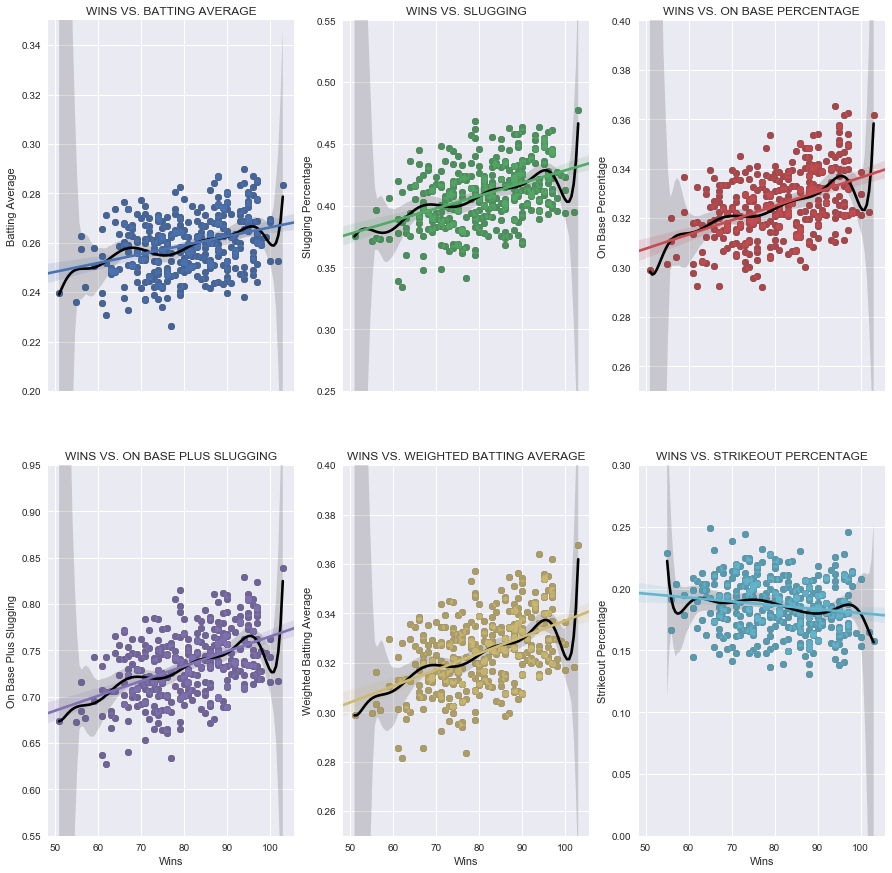

In [15]:
####### REGULAR SEASON CALCUALTED STATS TO WINS #######

fig, ax = plt.subplots(2,3,figsize=(15,15), sharex = True)

sns.regplot(x='w', y='bat_avg', data=team_rb_avg, ax=ax[0,0], order=10, truncate=True, color='black')
sns.regplot(x='w', y='bat_avg', data=team_rb_avg, ax=ax[0,0])
ax[0,0].set_title('WINS VS. BATTING AVERAGE')
ax[0,0].set_ylabel('Batting Average')
ax[0,0].set_xlabel('')
ax[0,0].set_ylim([.2,.35])
avg_slope, avg_intercept, avg_r_value, avg_p_value, avg_slope_std_error = scipy.stats.linregress(team_rb_avg.w, team_rb_avg.bat_avg)

sns.regplot(x='w', y='slg', data=team_rb_slg, ax=ax[0,1], order=10, truncate=True, color='black')
sns.regplot(x='w', y='slg', data=team_rb_slg, ax=ax[0,1])
ax[0,1].set_title('WINS VS. SLUGGING')
ax[0,1].set_ylabel('Slugging Percentage')
ax[0,1].set_xlabel('')
ax[0,1].set_ylim([.25,.55])
slg_slope, slg_intercept, slg_r_value, slg_p_value, slg_slope_std_error = scipy.stats.linregress(team_rb_slg.w, team_rb_slg.slg)

sns.regplot(x='w', y='obp', data=team_rb_obp, ax=ax[0,2], order=10, truncate=True, color='black')
sns.regplot(x='w', y='obp', data=team_rb_obp, ax=ax[0,2])
ax[0,2].set_title('WINS VS. ON BASE PERCENTAGE')
ax[0,2].set_ylabel('On Base Percentage')
ax[0,2].set_xlabel('')
ax[0,2].set_ylim([.25,.4])
obp_slope, obp_intercept, obp_r_value, obp_p_value, obp_slope_std_error = scipy.stats.linregress(team_rb_obp.w, team_rb_obp.obp)

sns.regplot(x='w', y='ops', data=team_rb_ops, ax=ax[1,0], order=10, truncate=True, color='black')
sns.regplot(x='w', y='ops', data=team_rb_ops, ax=ax[1,0])
ax[1,0].set_title('WINS VS. ON BASE PLUS SLUGGING')
ax[1,0].set_ylabel('On Base Plus Slugging')
ax[1,0].set_xlabel('Wins')
ax[1,0].set_ylim([.55,.95])
ops_slope, ops_intercept, ops_r_value, ops_p_value, ops_slope_std_error = scipy.stats.linregress(team_rb_ops.w, team_rb_ops.ops)

sns.regplot(x='w', y='woba', data=team_rb_woba, ax=ax[1,1], order=10, truncate=True, color='black')
sns.regplot(x='w', y='woba', data=team_rb_woba, ax=ax[1,1])
ax[1,1].set_title('WINS VS. WEIGHTED BATTING AVERAGE')
ax[1,1].set_ylabel('Weighted Batting Average')
ax[1,1].set_xlabel('Wins')
ax[1,1].set_ylim([.25,.4])
woba_slope, woba_intercept, woba_r_value, woba_p_value, woba_slope_std_error = scipy.stats.linregress(team_rb_woba.w, team_rb_woba.woba)

sns.regplot(x='w', y='kperc', data=team_rb_kperc, ax=ax[1,2], order=10, truncate=True, color='black')
sns.regplot(x='w', y='kperc', data=team_rb_kperc, ax=ax[1,2])
ax[1,2].set_title('WINS VS. STRIKEOUT PERCENTAGE')
ax[1,2].set_ylabel('Strikeout Percentage')
ax[1,2].set_xlabel('Wins')
ax[1,2].set_ylim([0,.3])
kperc_slope, kperc_intercept, kperc_r_value, kperc_p_value, kperc_slope_std_error = scipy.stats.linregress(team_rb_kperc.w, team_rb_kperc.kperc)
None

In [16]:
print('BATTING AVERAGE REGRESSION')
print('Slope:', avg_slope)
print('Intercept:', avg_intercept)
print('R value:', avg_r_value)
print('P value:', avg_p_value)
print('Slope Standard Deviation Error:', avg_slope_std_error)
print('')
print('SLUGGING REGRESSION')
print('Slope:', slg_slope)
print('Intercept:', slg_intercept)
print('R value:', slg_r_value)
print('P value:', slg_p_value)
print('Slope Standard Deviation Error:', slg_slope_std_error)
print('')
print('ON BASE REGRESSION')
print('Slope:', obp_slope)
print('Intercept:', obp_intercept)
print('R value:', obp_r_value)
print('P value:', obp_p_value)
print('Slope Standard Deviation Error:', obp_slope_std_error)
print('')
print('ON BASE PLUS SLUG REGRESSION')
print('Slope:', ops_slope)
print('Intercept:', ops_intercept)
print('R value:', ops_r_value)
print('P value:', ops_p_value)
print('Slope Standard Deviation Error:', ops_slope_std_error)
print('')
print('WIEGHTED ON BASE REGRESSION')
print('Slope:', woba_slope)
print('Intercept:', woba_intercept)
print('R value:', woba_r_value)
print('P value:', woba_p_value)
print('Slope Standard Deviation Error:', woba_slope_std_error)
print('')
print('K PERCENTAGE REGRESSION')
print('Slope:', kperc_slope)
print('Intercept:', kperc_intercept)
print('R value:', kperc_r_value)
print('P value:', kperc_p_value)
print('Slope Standard Deviation Error:', kperc_slope_std_error)
print('')
None

BATTING AVERAGE REGRESSION
Slope: 0.000359926258328
Intercept: 0.230220350913
R value: 0.322392241642
P value: 2.03300459357e-09
Slope Standard Deviation Error: 5.83527541811e-05

SLUGGING REGRESSION
Slope: 0.00102625135313
Intercept: 0.32600433518
R value: 0.426777084695
P value: 4.86647821195e-16
Slope Standard Deviation Error: 0.000120075820522

ON BASE REGRESSION
Slope: 0.000576081326309
Intercept: 0.278805526867
R value: 0.444918592419
P value: 1.90117786949e-17
Slope Standard Deviation Error: 6.40274714983e-05

ON BASE PLUS SLUG REGRESSION
Slope: 0.00160233267944
Intercept: 0.604809862047
R value: 0.458573631574
P value: 1.45266692588e-18
Slope Standard Deviation Error: 0.00017145121614

WIEGHTED ON BASE REGRESSION
Slope: 0.000662159523579
Intercept: 0.270884914027
R value: 0.46586397179
P value: 3.50797693938e-19
Slope Standard Deviation Error: 6.94447397391e-05

K PERCENTAGE REGRESSION
Slope: -0.000314879242441
Intercept: 0.211729043258
R value: -0.147900858856
P value: 0.00720

## Feature Selection

In [17]:
ncalc_wins = team_rb[['h', 'double', 'triple', 'hr', 'so', 'bb', 'w']]
calc_wins = team_rb[['bat_avg', 'slg', 'obp', 'ops', 'woba', 'kperc', 'w']]

In [18]:
team_rb.columns

Index(['year', 'league_id', 'team_id', 'franchise_id', 'div_id', 'rank', 'g',
       'ghome', 'w', 'l', 'div_win', 'wc_win', 'lg_win', 'ws_win', 'r', 'ab',
       'h', 'double', 'triple', 'hr', 'bb', 'so', 'sb', 'cs', 'hbp', 'sf',
       'ra', 'er', 'era', 'cg', 'sho', 'sv', 'ipouts', 'ha', 'hra', 'bba',
       'soa', 'e', 'dp', 'fp', 'name', 'park', 'attendance', 'bpf', 'ppf',
       'team_id_br', 'team_id_lahman45', 'team_id_retro', 'bat_avg', 'slg',
       'obp', 'ops', 'woba', 'kperc'],
      dtype='object')

In [19]:
from sklearn.linear_model import LinearRegression
ncalc = team_rb[['h', 'double', 'hr', 'so', 'bb']]
calc = team_rb[['bat_avg', 'slg', 'obp', 'ops', 'woba']]
wins = team_rb['w']
print('Non-Calculated Stats')
print(ncalc.head())
print('Calculated Stats')
print(calc.head())

Non-Calculated Stats
         h  double   hr      so   bb
2475  1419     291  191  1094.0  606
2476  1453     308  184  1084.0  534
2477  1492     296  189   902.0  447
2478  1579     339  199  1044.0  653
2479  1450     253  200  1002.0  435
Calculated Stats
       bat_avg       slg       obp       ops      woba
2475  0.255676  0.421081  0.332481  0.753562  0.332809
2476  0.264856  0.435108  0.332515  0.767623  0.337215
2477  0.268780  0.433976  0.327043  0.761019  0.334111
2478  0.280661  0.454497  0.356707  0.811204  0.356028
2479  0.262254  0.424851  0.322390  0.747241  0.328703


In [107]:
from sklearn.linear_model import LassoCV
from sklearn.datasets import load_boston
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

print(ncalc.shape)

m = SelectFromModel(LassoCV())

m.fit(ncalc, wins)
print(m.transform(ncalc).shape)

df_new = m.transform(ncalc)
df_new = pd.DataFrame(df_new)
df_new.columns = ['h', 'hr', 'bb']
df_new.head()

(330, 5)
(330, 3)


,h,hr,bb
0,1419.0,191.0,606.0
1,1453.0,184.0,534.0
2,1492.0,189.0,447.0
3,1579.0,199.0,653.0
4,1450.0,200.0,435.0


In [21]:
print(calc.shape)

m = SelectFromModel(LassoCV())

m.fit(calc, wins)
print(m.transform(calc).shape)

df_new1 = m.transform(calc)
df_new1 = pd.DataFrame(df_new1)
df_new1.columns = ['ops']
df_new1.head()

(330, 5)
(330, 1)


,ops
0,0.753562
1,0.767623
2,0.761019
3,0.811204
4,0.747241


## Linear Regression Model: Non-Calculated vs. Wins

In [22]:
lm = LinearRegression()
lm.fit(df_new, wins)
pred = np.round(lm.predict(df_new))

In [23]:
print('Estimated intercept coefficient:', lm.intercept_)

Estimated intercept coefficient: 15.0606575827


In [24]:
print('Number of coefficients:', len(lm.coef_))

Number of coefficients: 3


In [25]:
pd.DataFrame(list(zip(ncalc.columns, lm.coef_)), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,h,0.023096
1,double,0.078069
2,hr,0.039544


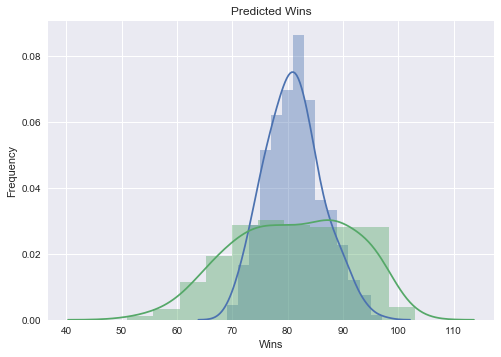

In [26]:
sns.distplot(pred)
sns.distplot(wins)
plt.title("Predicted Wins")
plt.xlabel("Wins")
plt.ylabel("Frequency")
plt.show()

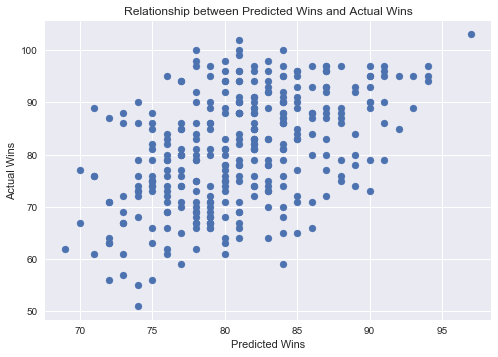

In [27]:
plt.scatter(pred, wins)
plt.xlabel("Predicted Wins")
plt.ylabel("Actual Wins")
plt.title("Relationship between Predicted Wins and Actual Wins")
plt.show()

In [28]:
print(np.sum((wins - pred) ** 2))

29129.0


In [29]:
from sklearn.metrics import mean_squared_error
print('RMSE:',np.sqrt(mean_squared_error(wins, pred)))

RMSE: 9.39519541945


## Linear Regression Model: Calculated Stats vs. Wins

In [152]:
lm = LinearRegression()
lm.fit(df_new1, wins)
pred = np.round(lm.predict(df_new1))

In [153]:
print('Estimated intercept coefficient:', lm.intercept_)

Estimated intercept coefficient: -15.4157594253


In [154]:
print('Number of coefficients:', len(lm.coef_))

Number of coefficients: 1


In [157]:
pd.DataFrame(list(zip(df_new1.columns, lm.coef_)), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,ops,131.239772


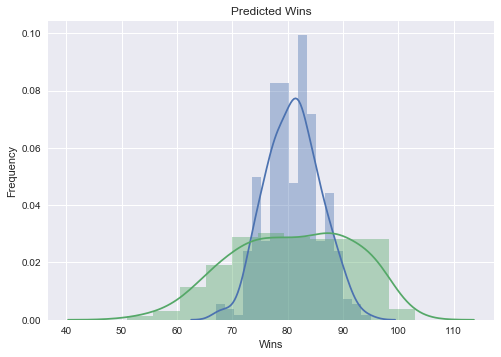

In [158]:
sns.distplot(pred)
sns.distplot(wins)
plt.title("Predicted Wins")
plt.xlabel("Wins")
plt.ylabel("Frequency")
plt.show()

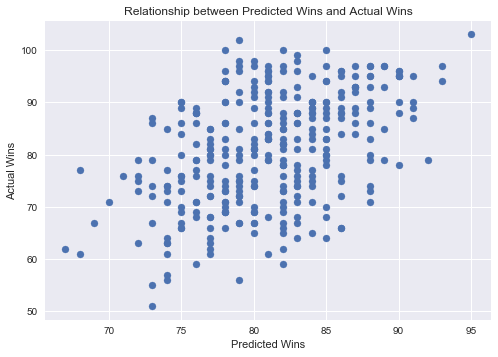

In [159]:
plt.scatter(pred, wins)
plt.xlabel("Predicted Wins")
plt.ylabel("Actual Wins")
plt.title("Relationship between Predicted Wins and Actual Wins")
plt.show()

In [160]:
from sklearn.metrics import mean_squared_error
print('RMSE:',np.sqrt(mean_squared_error(wins, pred)))

RMSE: 9.5209497871


## Splitting Training and Testing Data for Non-Calculated Stats

In [30]:
from sklearn.cross_validation import train_test_split
from sklearn import model_selection as cvl

C:\Users\lawew\OneDrive\Documents\New folder\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df_new, wins, test_size=0.33, random_state = 5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(221, 3)
(109, 3)
(221,)
(109,)


In [32]:
lm = LinearRegression()
model = lm.fit(X_train, Y_train)
pred = lm.predict(X_test)

print('Accuracy Score:',model.score(X_test, Y_test))
print('RMSE',np.sqrt(mean_squared_error(Y_test,pred)))

Accuracy Score: 0.275441911616
RMSE 9.38956108709


In [33]:
lm = LinearRegression()
y_pred = np.round(cvl.cross_val_predict(lm, df_new, wins, cv=100))
print('RMSE:',np.sqrt(mean_squared_error(wins,y_pred)))

RMSE: 9.49928226954


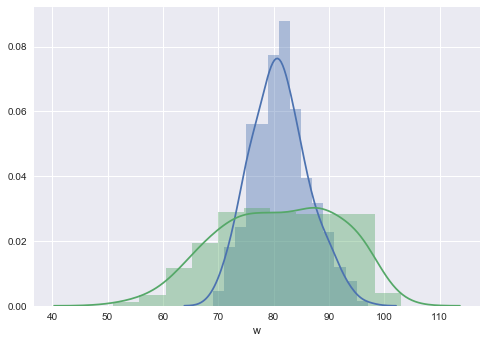

In [34]:
sns.distplot(y_pred)
sns.distplot(wins)

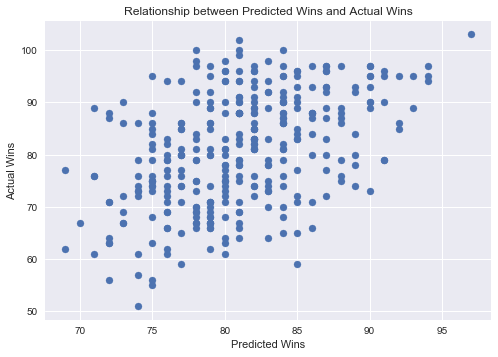

In [35]:
plt.scatter(y_pred, wins)
plt.xlabel("Predicted Wins")
plt.ylabel("Actual Wins")
plt.title("Relationship between Predicted Wins and Actual Wins")
plt.show()

## Linear Regression Model: Calculated Stats vs. Wins

In [36]:
lm = LinearRegression()
lm.fit(df_new1, wins)
pred1 = np.round(lm.predict(df_new1))

In [37]:
print('Estimated intercept coefficient:', lm.intercept_)

Estimated intercept coefficient: -15.4157594253


In [38]:
print('Number of coefficients:', len(lm.coef_))

Number of coefficients: 1


In [39]:
pd.DataFrame(list(zip(df_new1.columns, lm.coef_)), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,ops,131.239772


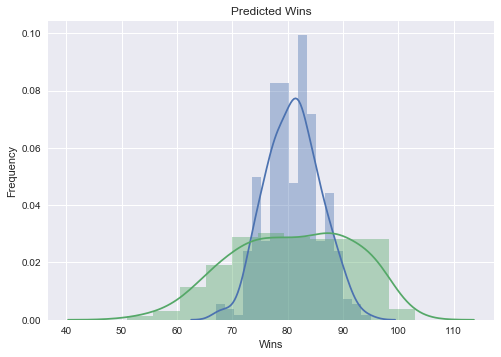

In [40]:
sns.distplot(pred1)
sns.distplot(wins)
plt.title("Predicted Wins")
plt.xlabel("Wins")
plt.ylabel("Frequency")
plt.show()

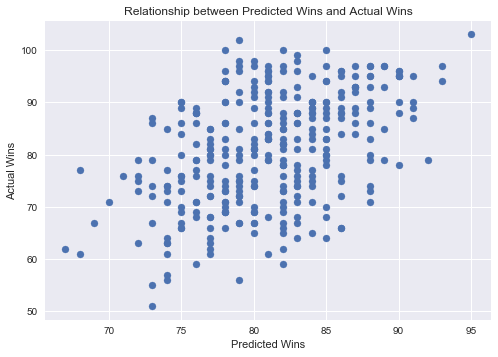

In [41]:
plt.scatter(pred1, wins)
plt.xlabel("Predicted Wins")
plt.ylabel("Actual Wins")
plt.title("Relationship between Predicted Wins and Actual Wins")
plt.show()

In [42]:
print(np.sum((wins - pred1) ** 2))

29914.0


In [43]:
print('RMSE:', np.sqrt(mean_squared_error(wins, pred1)))

RMSE: 9.5209497871


## Splitting Training and Testing Data for Calculated Stats

In [44]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(
    df_new1, wins, test_size=0.33, random_state = 5)
print(X1_train.shape)
print(X1_test.shape)
print(Y1_train.shape)
print(Y1_test.shape)

(221, 1)
(109, 1)
(221,)
(109,)


In [45]:
lm = LinearRegression()
model = lm.fit(X1_train, Y1_train)
pred1 = lm.predict(X1_test)

print('Accuracy Score:',model.score(X1_test, Y1_test))
print('RMSE',np.sqrt(mean_squared_error(Y1_test,pred1)))

Accuracy Score: 0.233675668088
RMSE 9.65639438647


In [46]:
lm = LinearRegression()
y_pred1 = np.round(cvl.cross_val_predict(lm, df_new1, wins, cv=100))
print('RMSE:',np.sqrt(mean_squared_error(wins,y_pred1)))

RMSE: 9.56841394666


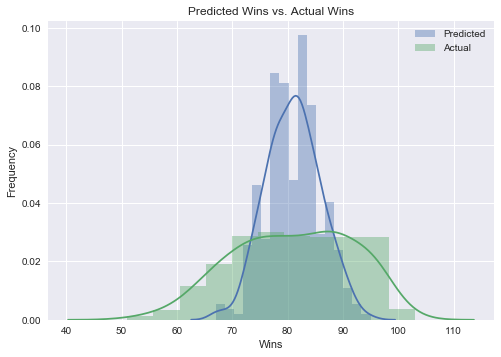

In [47]:
sns.distplot(y_pred1, label='Predicted')
sns.distplot(wins, label='Actual')
plt.title("Predicted Wins vs. Actual Wins")
plt.xlabel("Wins")
plt.ylabel("Frequency")
plt.legend()

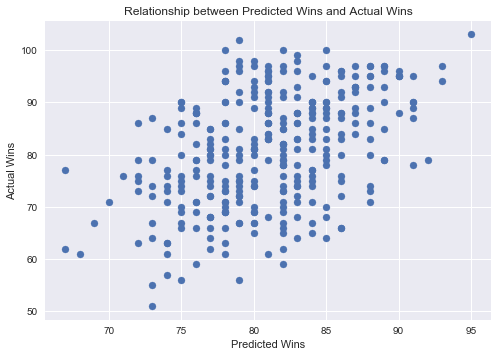

In [48]:
plt.scatter(y_pred1, wins)
plt.xlabel("Predicted Wins")
plt.ylabel("Actual Wins")
plt.title("Relationship between Predicted Wins and Actual Wins")
plt.show()

## Support Vector Machine (SVM): Non-Calculated vs. Wins

In [49]:
from sklearn.svm import SVC

In [145]:
clf = SVC(C=1, gamma=10, kernel='rbf')

In [146]:
clf.fit(df_new, wins)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [147]:
pred = clf.predict(df_new)
pred[0:5]

array([77, 90, 74, 95, 99], dtype=int64)

In [148]:
clf.score(df_new, wins)

1.0

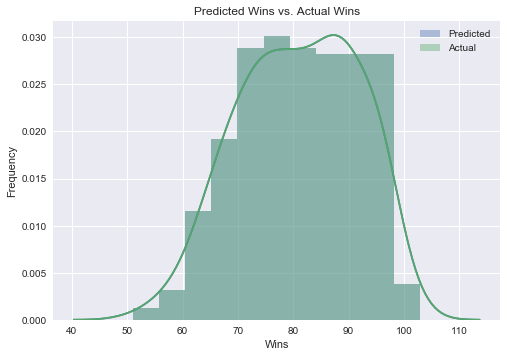

In [149]:
sns.distplot(pred, label='Predicted')
sns.distplot(wins, label='Actual')
plt.title("Predicted Wins vs. Actual Wins")
plt.xlabel("Wins")
plt.ylabel("Frequency")
plt.legend()

In [150]:
test_season = pd.DataFrame.from_csv('data/2016season.csv', index_col = None)
test_season = test_season[['H', 'HR', 'BB']]
print(df_new.shape)
print(test_season.shape)

(330, 3)
(32, 3)


In [151]:
clf.predict(test_season)

array([88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
       88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88], dtype=int64)

In [125]:
clf = SVC(C=1, gamma=1, kernel='rbf')

In [111]:
clf.fit(df_new1, wins)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [112]:
pred1 = clf.predict(df_new1)
pred1[0:5]

array([88, 88, 88, 88, 88], dtype=int64)

In [113]:
clf.score(df_new1, wins)

0.048484848484848485

C:\Users\lawew\OneDrive\Documents\New folder\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\lawew\OneDrive\Documents\New folder\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


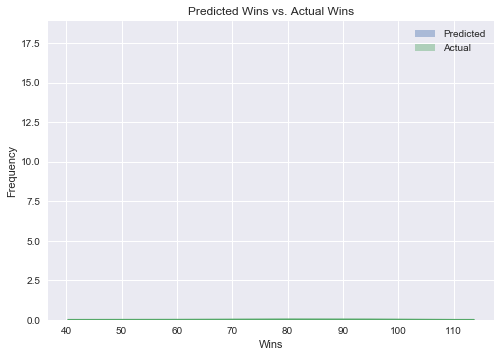

In [114]:
sns.distplot(pred, label='Predicted')
sns.distplot(wins, label='Actual')
plt.title("Predicted Wins vs. Actual Wins")
plt.xlabel("Wins")
plt.ylabel("Frequency")
plt.legend()